In [1]:
!pip install spectral
!pip install tensorflow
import os
import sys
import torch
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import io
from scipy.io import loadmat
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import keras
import spectral
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Dropout, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from operator import truediv
from plotly.offline import init_notebook_mode
import spectral
from tensorflow.keras import utils
init_notebook_mode(connected=True)
%matplotlib inline
#from test_utils import summary, comparator

In [2]:
dataset_folder = "Indian_pines_corrected.mat"
ground_truth_folder = "Indian_pines_gt.mat"
dataset_data = io.loadmat(dataset_folder)
ground_truth_data = io.loadmat(ground_truth_folder)
print("Keys in dataset_data:", dataset_data.keys())
print("Keys in ground_truth_data:", ground_truth_data.keys())

variable_name = 'indian_pines_corrected' #th the actual variable name
if variable_name in dataset_data:
    data = dataset_data[variable_name]
    print("Data shape:", data.shape)
    print("Data content:", data[1])
else:
    print(f"Variable '{variable_name}' not found in the .mat file.")
    
variable_name = 'indian_pines_gt' #th the actual variable name
if variable_name in ground_truth_data:
    data_gt = ground_truth_data[variable_name]
    print("Data shape:", data_gt.shape)
    print("Data content:", data_gt)
else:
    print(f"Variable '{variable_name}' not found in the .mat file.")

Keys in dataset_data: dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_corrected'])
Keys in ground_truth_data: dict_keys(['__header__', '__version__', '__globals__', 'indian_pines_gt'])
Data shape: (145, 145, 200)
Data content: [[2576 4388 4334 ... 1047 1030 1006]
 [2747 4264 4592 ... 1055 1039 1015]
 [2750 4268 4423 ... 1047 1026 1015]
 ...
 [3859 4512 4605 ... 1056 1035 1015]
 [3686 4264 4690 ... 1051 1012 1020]
 [2744 4268 4597 ... 1047 1019 1016]]
Data shape: (145, 145)
Data content: [[3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 [3 3 3 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [24]:
target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']

# Data Processing

In [3]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [4]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [5]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [6]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [7]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

In [8]:
test_ratio = 0.3
windowSize = 25
X, y = data, data_gt
X.shape, y.shape

((145, 145, 200), (145, 145))

In [9]:
K = X.shape[2]
K = 30
X,pca = applyPCA(X,numComponents=K)
X.shape

(145, 145, 30)

In [10]:
X, y = createImageCubes(X, y, windowSize=windowSize)
X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [11]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)
Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((7174, 25, 25, 30), (3075, 25, 25, 30), (7174,), (3075,))

# Model

In [12]:
from keras.layers import Input, Conv2D, BatchNormalization, Activation, DepthwiseConv2D, AveragePooling2D, GlobalAveragePooling2D, Dense

def depthwise_separable_block(x, filters, strides):
    # Depthwise convolution
    x = DepthwiseConv2D(kernel_size=(3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Pointwise convolution
    x = Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

def custom_mobilenet(input_shape=(25, 25, 30), num_classes=16):
    input_tensor = Input(shape=input_shape)
    
    # Initial Convolution Layer
    x = Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Depthwise separable blocks
    x = depthwise_separable_block(x, 64, (1, 1))
    x = depthwise_separable_block(x, 128, (2, 2))
    x = depthwise_separable_block(x, 128, (1, 1))
    x = depthwise_separable_block(x, 256, (2, 2))
    x = depthwise_separable_block(x, 256, (1, 1))
    x = depthwise_separable_block(x, 512, (2, 2))
    
    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    
    # Fully connected layer
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=input_tensor, outputs=x)
    
    return model


# Training

In [13]:
# Create a custom MobileNet-like model for hyperspectral data
model = custom_mobilenet(input_shape=(25,25,30), num_classes=16)
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Print the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 30)]      0         
                                                                 
 conv2d (Conv2D)             (None, 13, 13, 32)        8672      
                                                                 
 batch_normalization (Batch  (None, 13, 13, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 13, 13, 32)        0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 13, 13, 32)        320       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 13, 13, 32)        128   

In [14]:
print ("number of training examples = " + str(Xtrain.shape[0]))
print ("number of test examples = " + str(Xtest.shape[0]))
print ("X_train shape: " + str(Xtrain.shape))
print ("Y_train shape: " + str(ytrain.shape))
print ("X_test shape: " + str(Xtest.shape))
print ("Y_test shape: " + str(ytest.shape))

number of training examples = 7174
number of test examples = 3075
X_train shape: (7174, 25, 25, 30)
Y_train shape: (7174,)
X_test shape: (3075, 25, 25, 30)
Y_test shape: (3075,)


In [15]:
from tensorflow.keras.utils import to_categorical
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9)
adam = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

filepath = "best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

Y_train_encoded = to_categorical(ytrain, num_classes=16)
Y_test_encoded = to_categorical(ytest, num_classes=16)

model.fit(Xtrain, Y_train_encoded, epochs = 100, batch_size = 32)

Epoch 1/100
225/225 [==============================] - 9s 22ms/step - loss: 0.9484 - accuracy: 0.6999
Epoch 2/100
225/225 [==============================] - 5s 23ms/step - loss: 0.1195 - accuracy: 0.9675
Epoch 3/100
225/225 [==============================] - 6s 25ms/step - loss: 0.0327 - accuracy: 0.9922
Epoch 4/100
225/225 [==============================] - 6s 25ms/step - loss: 0.0256 - accuracy: 0.9928
Epoch 5/100
225/225 [==============================] - 6s 26ms/step - loss: 0.0566 - accuracy: 0.9824
Epoch 6/100
225/225 [==============================] - 6s 26ms/step - loss: 0.0358 - accuracy: 0.9898
Epoch 7/100
225/225 [==============================] - 6s 26ms/step - loss: 0.0124 - accuracy: 0.9964
Epoch 8/100
225/225 [==============================] - 6s 26ms/step - loss: 0.0085 - accuracy: 0.9979
Epoch 9/100
225/225 [==============================] - 6s 26ms/step - loss: 0.0031 - accuracy: 0.9992
Epoch 10/100
225/225 [==============================] - 6s 26ms/step - loss: 0.039

225/225 [==============================] - 6s 26ms/step - loss: 0.0014 - accuracy: 0.9997
Epoch 81/100
225/225 [==============================] - 6s 26ms/step - loss: 0.0068 - accuracy: 0.9994
Epoch 82/100
225/225 [==============================] - 6s 27ms/step - loss: 0.0020 - accuracy: 0.9994
Epoch 83/100
225/225 [==============================] - 6s 27ms/step - loss: 0.0044 - accuracy: 0.9985
Epoch 84/100
225/225 [==============================] - 6s 27ms/step - loss: 0.0173 - accuracy: 0.9968
Epoch 85/100
225/225 [==============================] - 6s 26ms/step - loss: 0.0029 - accuracy: 0.9992
Epoch 86/100
225/225 [==============================] - 6s 26ms/step - loss: 8.2287e-04 - accuracy: 0.9996
Epoch 87/100
225/225 [==============================] - 6s 27ms/step - loss: 0.0046 - accuracy: 0.9987
Epoch 88/100
225/225 [==============================] - 6s 26ms/step - loss: 0.0055 - accuracy: 0.9986
Epoch 89/100
225/225 [==============================] - 6s 26ms/step - loss: 0.002

In [16]:
model.save("best-model.hdf5")

C:\Users\vaish\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



# Validation

In [17]:
results = model.evaluate(Xtest, Y_test_encoded, batch_size=32)  # Replace X_test and Y_test_encoded with your actual test data

# Print the evaluation results
print("Test loss:", results[0])
print("Test accuracy:", results[1])

97/97 [==============================] - 2s 9ms/step - loss: 2.1910e-05 - accuracy: 1.0000
Test loss: 2.1909960196353495e-05
Test accuracy: 1.0


In [18]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K)
print(Xtest.shape)
ytest = utils.to_categorical(ytest)
print(ytest.shape)

(3075, 25, 25, 30)
(3075, 16)


In [19]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

97/97 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00       428
           2       1.00      1.00      1.00       249
           3       1.00      1.00      1.00        71
           4       1.00      1.00      1.00       145
           5       1.00      1.00      1.00       219
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00       143
           8       1.00      1.00      1.00         6
           9       1.00      1.00      1.00       292
          10       1.00      1.00      1.00       737
          11       1.00      1.00      1.00       178
          12       1.00      1.00      1.00        61
          13       1.00      1.00      1.00       380
          14       1.00      1.00      1.00       116
          15       1.00      1.00      1.00        28

    accuracy               

In [20]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [21]:
def reports (Xtest,ytest):
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    
    
    classification = classification_report(np.argmax(ytest, axis=1), y_pred_test, target_names=target_names)
    oa = accuracy_score(np.argmax(ytest, axis=1), y_pred_test)
    confusion = confusion_matrix(np.argmax(ytest, axis=1), y_pred_test)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(ytest, axis=1), y_pred_test)
    score = model.evaluate(Xtest, ytest, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [22]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

print(Test_loss, Test_accuracy, oa, each_acc, aa, kappa)
with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

97/97 [==============================] - 1s 7ms/step - loss: 2.1910e-05 - accuracy: 1.0000
0.0021909960196353495 100.0 100.0 [100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100. 100.
 100. 100.] 100.0 100.0


97/97 [==============================] - 1s 11ms/step


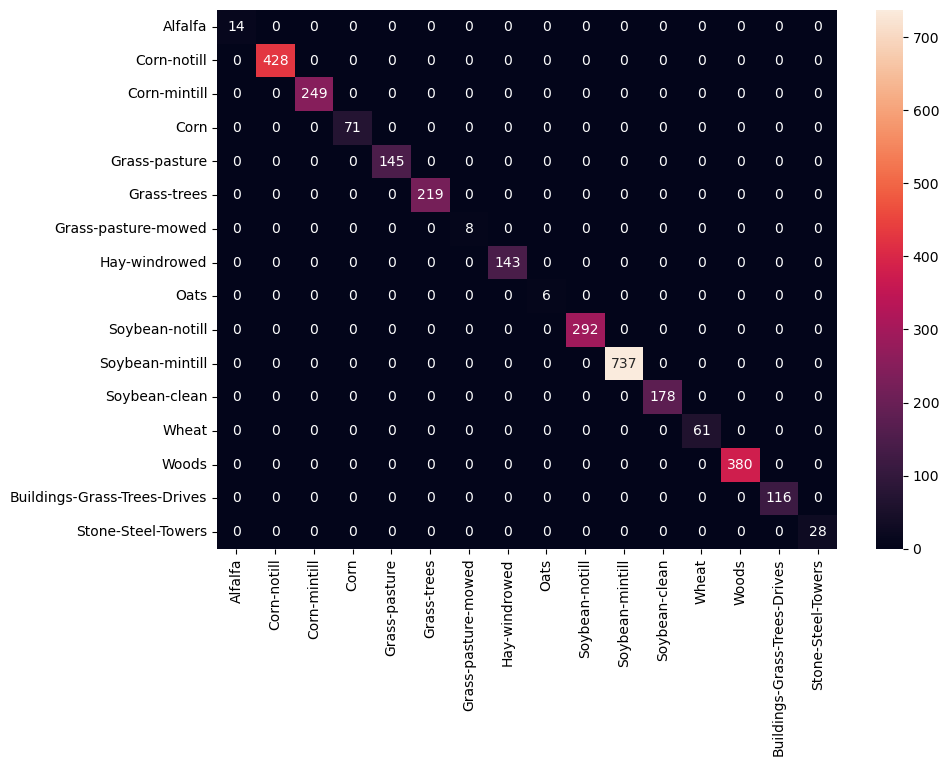

In [25]:
import seaborn as sns
plt.figure(figsize = (10,7))
pred = np.argmax(model.predict(Xtest), axis=1)
classes = target_names
mat = confusion_matrix(np.add(pred, 1), np.add(np.argmax(ytest, 1), 1))
df_cm = pd.DataFrame(mat, index = classes, columns = classes)
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()